# Determination of stellar luminosities

## Scope of the notebook
This notebook loosely follows the methodology from [Villebrun++2019](https://www.aanda.org/articles/aa/full_html/2019/02/aa33545-18/aa33545-18.html) section 3.1.2  to determine stellar luminosities from observed V and j magnitudes. We want to compute the stellar luminosity *L* in order to place the stars on a HR diagram. Intrinsic colours for young stars and bolometric corrections are adopted from [Pecaut+Mamajek 2013](http://iopscience.iop.org/article/10.1088/0067-0049/208/1/9/meta#apjs480616s3) 

## Methodology
*L* is obtained with:

$$
\frac{L}{L_☉} = 10^{-(M_{\text{bol}} - M_{\text{bol,☉}})/2.5}
$$
> where $ M_\text{bol} $ is the bolometric luminosity of the star, and $ M_{\text{bol,☉}}$ the bolometric luminosity of the Sun, that should be taken from the same source than the bolometric correction

$$
M_\text{bol} = M_j + BC_j
$$
> where $M_j$ is the absolute magnitude in the j band, and $BC_j$ the bolometric correction

$$
M_j = m_j + 5 + 5 \text{ log}_{10}(p - A_j)
$$
> where $m_j$ is the apparent j magnitude, $p$ is the parallax in arcseconds, and $A_j$ is the extinction in the j band

$$
A_j =  R_j × E(V-j)
$$
> where $R_j$ = 0.437 and is the total to selective extinction, $E(V-j)$ is the colour excess

$$
E(V-j) = (m_V - m_j) - (V-j)_0
$$
> where $(V-j)_0$ is the empirical intrinsic colour

## Input data
* Effective temperatures $T_{\text{eff}}$ (required to compute intrinsic colours, and bolometric corrections) are taken from the litterature and listed in the paper with relevant citations for the sample of paper III, and taken from the literature for the literature sample
* $j$ magnitudes are taken from 2MASS through the [NASA/IPAC Infrared Science Archive](https://irsa.ipac.caltech.edu/frontpage/), also accessed through `astroquery`
* $V$ magnitudes are taken from the literature: [Bouvier+Appenzeller 1992](http://adsbit.harvard.edu//full/1992A%26AS...92..481B/0000495.000.html) (V2247 Oph, V2058 Oph), [Torres++2006](https://ui.adsabs.harvard.edu/?#abs/2006A%26A...460..695T) and references therein (all other stars) for the paper III sample, and simply pulled from Simbad for the literature sample through `astroquery` (with the exception of Par 2441 for which the value is taken from NOMAD catalogue)
* Parallaxes are taken from GAIA DR2 and were queried through the [GAIA archive](http://gea.esac.esa.int/archive/) 
* Bolometric corrections $BC_j$, intrinsic colours $(V-j)_0$ were adopted from Pecaut+Mamajek 2013 (See the notebook below).
* The total to selective extinction $R_j = 0.437$ is adopted from Villebrun++2019
* The bolometric luminosity of the Sun $ M_{\text{bol,☉}} = 4.755$ is adopted from Pecaut+Mamajet 2013

## Let's get started

In [15]:
# Importing the classic culprits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from astroquery.irsa import Irsa
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import astropy.units as u

# Plotting parameters
plt.rcParams['figure.figsize'] = [14, 4]
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "Roboto"

### Intrinsic colours *(V-j)_0* as a function of *T*_eff

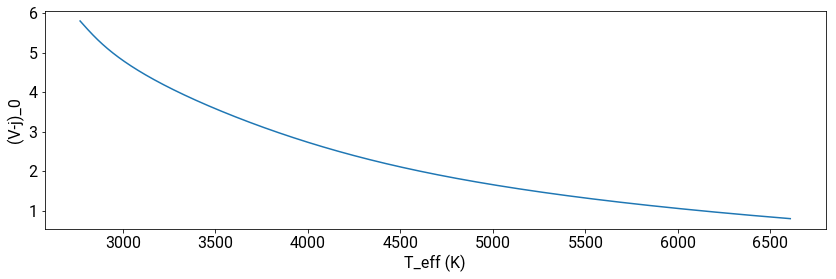

In [16]:
# teff_vj() is the function returning the effective temperature T_eff as a function of (V-J) colour. This function is spilled out as a polynomial function in Pecaut & Mamajek
def teff_vj(vj):
    temp = (9.593475 *10.**3.) - (5.095204 *10.**3 *vj) + (2.053259 * 10.**3. * vj**2) - (4.813940 * 100. * vj**3) + (5.816754 * 10. * vj**4) - (2.779565*vj**5) 
    return temp

# creating a big array in (V-j) filling the domain of the function
vj_arr = np.arange(5001)/1000. + 0.8

# computing the corresponding big array in T_eff
teff_vj_arr = teff_vj(vj_arr)

# Plot the function to check it looks OK
plt.plot(teff_vj_arr,vj_arr)
plt.xlabel("T_eff (K)")
plt.ylabel("(V-j)_0")
plt.show()

# Interpolate the (V-J)_0 array with the T_eff array to inverse the function and get (V-J) as a function of effective temperature
fvj = interp1d(teff_vj_arr, vj_arr, kind='cubic')


### Bolometric corrections *BC_j* as a function of *T*_eff

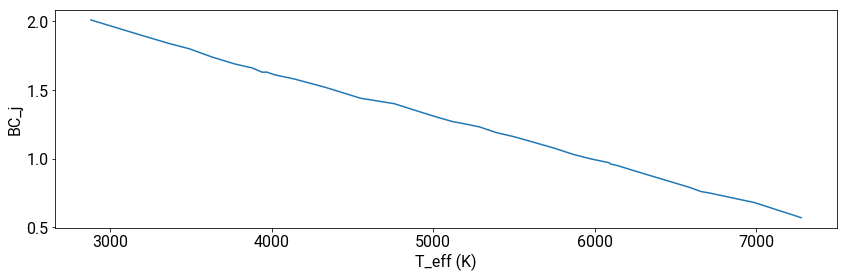

0.68


In [17]:
# This is a copy-paste from Table 6 in Pecaut+Mamajek 2013 <https://iopscience.iop.org/article/10.1088/0067-0049/208/1/9/meta#apjs480616t6>
teff_arr = np.array([7280,6990,6710,6660,6590,6420,6250,6140,6100,6090,6050,5970,5870,5740,5620,5500,5390,5290,5210,5120,5030,4920,4760,4550,4330,4140,4020,3970,3940,3880,3770,3630,3490,3360,3160,2880])
bcj_arr=np.array([0.57,0.68,0.75,0.76,0.79,0.85,0.91,0.95,0.96,0.97,0.98,1.00,1.03,1.08,1.12,1.16,1.19,1.23,1.25,1.27,1.30,1.34,1.40,1.44,1.52,1.58,1.61,1.63,1.63,1.66,1.69,1.74,1.80,1.84,1.91,2.01])

# Interpolating the arrays
fbcj=interp1d(teff_arr,bcj_arr,kind='linear')

# Plotting 
plt.plot(teff_arr, fbcj(teff_arr))
plt.xlabel("T_eff (K)")
plt.ylabel("BC_j")
plt.show()

print(fbcj(6990))

### Computing the luminosities for the sample in the paper

In [35]:
# All input data on the sample
teff = np.array([3300,3400,3500,3800,4000,4075,4500,4500])
stars = ["TWA 7","TWA 8A","V2247 Oph","V2058 Oph","TWA 9A", "TW Hya", "V2129 Oph","V1121 Oph"]
Vmag = np.array([11.7,12.2,13.4,12.8,11.3,11.1,11.6,11.4])
jmag = np.array([7.79,8.34,9.42,9.15,8.68,8.22,8.44,8.30])
B = np.array([2.7,4.2,2.7,1.3,2.8,3.1,4.3,3.4])
parallax = np.array([29.4,21.6,8.9,7.4,13.1,16.6,7.7,8.3]) # parallax in mas
parallax = parallax * 0.001 # parallax in arcsecond
Rj = 0.437

#### just following through the equations

In [36]:
# Computing observed (V-j) colours
VJmag = Vmag - jmag

# Computing bolometric corrections and intrinsic colours
bcj = fbcj(teff)
vj0 = fvj(teff)

# Computing the colour excess
Evj = VJmag - vj0
Evj[Evj < 0.] = 0.
# Computing extinction
Aj = Rj * Evj

# If some values are slightly negative - replace by 0

# Computing bolometric luminosities
Mbol = bcj + jmag + 5. + 5.*np.log10(parallax) - Aj

# Computing log(L/Lsun)
logLLsun = -(Mbol - 4.755) / 2.5

# Computing L/Lsun
L = 10.**logLLsun


#### Printing the results now :)

In [37]:
print("")
print("{:10s}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("Star","jmag","Vmag","BC_j", "(V-j)0", "E(V_j)", "A_j", "M_bol", "L/Lsun", " logL", "Teff", "<B>"))
print("---------------------------------------------------------------------------------------------------------")
for i in range(len(stars)):
    print("'{:10s}'\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.0f}\t{:.2f}".format(stars[i],jmag[i], Vmag[i], bcj[i], vj0[i], Evj[i], Aj[i], Mbol[i],  L[i],logLLsun[i],teff[i],B[i]))
    #print("'{:10s}'\t{:.2f}\t{:.0f}\t{:.2f}".format(stars[i],logLLsun[i],teff[i],B[i]))
    


Star      	jmag	Vmag	BC_j	(V-j)0	E(V_j)	A_j	M_bol	L/Lsun	 logL	Teff	<B>
---------------------------------------------------------------------------------------------------------
'TWA 7     '	7.79	11.70	1.86	4.00	0.00	0.00	6.99	0.13	-0.90	3300	2.70
'TWA 8A    '	8.34	12.20	1.83	3.78	0.08	0.03	6.81	0.15	-0.82	3400	4.20
'V2247 Oph '	9.42	13.40	1.80	3.58	0.40	0.17	5.79	0.39	-0.41	3500	2.70
'V2058 Oph '	9.15	12.80	1.68	3.04	0.61	0.27	4.91	0.87	-0.06	3800	1.30
'TWA 9A    '	8.68	11.30	1.62	2.73	0.00	0.00	5.88	0.35	-0.45	4000	2.80
'TW Hya    '	8.22	11.10	1.60	2.62	0.26	0.11	5.81	0.38	-0.42	4075	3.10
'V2129 Oph '	8.44	11.60	1.46	2.11	1.05	0.46	3.87	2.26	0.35	4500	4.30
'V1121 Oph '	8.30	11.40	1.46	2.11	0.99	0.43	3.92	2.16	0.33	4500	3.40


### Computing the luminosities for the sample from the literature

In [7]:
stars = ["CHXR 28","Ylw 19","Coup 107","V2062 Oph","Par 2441","V1227 Ori","2MASS J05351281-0520436","V1123 Ori","OV Ori","V1348 Ori","LO Ori","V568 Ori","LW Ori","V1568 Ori","2MASS J05361049-0519449","2MASS J05350475-0526380","V1124 Ori","AA Tau","BP Tau","CY Tau","DE Tau","DF Tau","DG Tau","DH Tau","DK Tau","DN Tau","GI Tau","GK Tau","T Tau","TWA 9B"]
parallax = np.array([5.9,7.0,2.5,6.9,2.4,2.5,2.5,2.5,2.5,2.5,2.5,2.6,2.5,0.4,2.5,2.5,2.8,7.3,7.7,7.8,7.9,8.0,8.3,7.4,7.8,7.8,7.7,7.7,6.9,13.1]) # parallax in mas
parallax = parallax * 0.001 # parallax in arcsecond
teff = np.array([4060,4590,4730,4730,5875,4200,3500,3800,4000,3800,3900,3664,3800,4000,4200,3664,3589,4040,4040,3680,3605,3530,4166,3680,4040,3800,4040,4040,5240,3400])
B = np.array([1.5,0.8,0.1,1.8,0.8,2.13,1.81,2.43,1.64,3.05,3.26,1.59,1.32,1.42,2.28,2.81,2.17,2.78,2.17,1.16,1.12,2.9,2.55,2.68,2.64,2,2.73,2.28,2.37,3.3])
Rj = 0.437

#### Fetching the j magnitudes from the 2MASS Point Source Catalogue

In [8]:
jmag = np.zeros(len(stars))
for i in range(len(stars)):
    table = Irsa.query_region(stars[i],catalog='fp_psc', spatial='Box', selcols="ra,dec,designation,j_m,j_cmsig,j_snr",width=5 * u.arcsec)
    jmag[i] = table[0][5]

#### Fetching the V magnitudes from Simbad

In [9]:
#Simbad.list_votable_fields()
#https://astroquery.readthedocs.io/en/latest/simbad/simbad.html#specifying-which-votable-fields-to-include-in-the-result

customSimbad = Simbad()
#customSimbad.get_votable_fields()

customSimbad.add_votable_fields('flux(V)', 'flux_error(V)', 'flux_bibcode(V)')
#customSimbad.get_votable_fields()

# i == 4 is Par 2441, there's no Vmag from Simbad. I got the value from NOMAD
Vmag = np.zeros(len(stars))
for i in range(len(stars)):
    if i == 4:
        zzz = 0
    else:
        result_table = customSimbad.query_object(stars[i])
        Vmag[i] = result_table[0][11]

Vmag[4] = 10.751 # Taken from NOMAD catalogue

print("")
print("{:26s}\t{}\t{}".format("Star","Vmag", "jmag"))
print("-------------------------------------------------")
for i in range(len(stars)):
    print("{:26s}\t{:.2f}\t{:.2f}".format(stars[i],Vmag[i],jmag[i]))


Star                      	Vmag	jmag
-------------------------------------------------
CHXR 28                   	13.49	9.21
Ylw 19                    	16.40	10.42
Coup 107                  	11.92	8.95
V2062 Oph                 	12.80	9.23
Par 2441                  	10.75	9.43
V1227 Ori                 	14.54	11.41
2MASS J05351281-0520436   	15.46	11.52
V1123 Ori                 	14.11	11.07
OV Ori                    	15.24	11.51
V1348 Ori                 	15.43	11.78
LO Ori                    	15.94	11.79
V568 Ori                  	15.69	11.79
LW Ori                    	16.08	12.99
V1568 Ori                 	14.93	11.50
2MASS J05361049-0519449   	14.00	11.49
2MASS J05350475-0526380   	16.21	11.97
V1124 Ori                 	15.25	11.65
AA Tau                    	12.20	9.43
BP Tau                    	10.70	9.10
CY Tau                    	13.40	9.83
DE Tau                    	13.80	9.18
DF Tau                    	11.42	8.17
DG Tau                    	10.50	8.69
DH Tau                   

#### just following through the equations

In [21]:
# Computing observed (V-j) colours
VJmag = Vmag - jmag

# Computing bolometric corrections and intrinsic colours
bcj = fbcj(teff)
vj0 = fvj(teff)

# Computing the colour excess
Evj = VJmag - vj0

# Computing extinction
Aj = Rj * Evj
# If some values are slightly negative - replace by 0
#Aj[Aj < 0.] = 0.
# Computing bolometric luminosities
Mbol = bcj + jmag + 5. + 5.*np.log10(parallax) - Aj

# Computing log(L/Lsun)
logLLsun = -(Mbol - 4.755) / 2.5

# Computing L/Lsun
L = 10.**logLLsun


#### printing the results

In [22]:
print("")
print("{:25s}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("Star","BC_j", "(V-j)0", "E(V_j)", "A_j", "M_bol", "L/Lsun", "logL", "Teff", "B"))
print("-----------------------------------------------------------------------------------------------------")
for i in range(len(stars)):
    print("'{:25s}'\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:4.0f}\t{:.2f}".format(stars[i],bcj[i], vj0[i], Evj[i], Aj[i], Mbol[i],  L[i], logLLsun[i],teff[i],B[i]))
    #print("'{:25s}'\t{:.2f}\t{:4.0f}\t{:.2f}".format(stars[i],logLLsun[i],teff[i],B[i]))


Star                     	BC_j	(V-j)0	E(V_j)	A_j	M_bol	L/Lsun	logL	Teff	B
-----------------------------------------------------------------------------------------------------
'TWA 7                    '	1.86	4.00	-0.09	0.00	6.99	0.13	-0.90	3300	2.70
'TWA 8A                   '	1.83	3.78	0.08	0.03	6.81	0.15	-0.82	3400	4.20
'V2247 Oph                '	1.80	3.58	0.40	0.17	5.79	0.39	-0.41	3500	2.70
'V2058 Oph                '	1.68	3.04	0.61	0.27	4.91	0.87	-0.06	3800	1.30
'TWA 9A                   '	1.62	2.73	-0.11	0.00	5.88	0.35	-0.45	4000	2.80
'TW Hya                   '	1.60	2.62	0.26	0.11	5.81	0.38	-0.42	4075	3.10
'V2129 Oph                '	1.46	2.11	1.05	0.46	3.87	2.26	0.35	4500	4.30
'V1121 Oph                '	1.46	2.11	0.99	0.43	3.92	2.16	0.33	4500	3.40


#### just doing V1149 Sco separately to check with Villebrun++2019 if results are consistent

In [23]:
star = ["V1149 Sco"]
teff = np.array([5740.])
parallax = np.array([1./166.]) # d= 166 pc from Villebrun
Vmag = np.array([10.14])
jmag = np.array([8.358])

In [24]:
# Computing observed (V-j) colours
VJmag = Vmag - jmag

# Computing bolometric corrections and intrinsic colours
bcj = fbcj(teff)
vj0 = fvj(teff)

# Computing the colour excess
Evj = VJmag - vj0

# Computing extinction
Aj = Rj * Evj

# Computing bolometric luminosities
Mbol = bcj + jmag + 5. + 5.*np.log10(parallax) - Aj

# Computing log(L/Lsun)
logLLsun = -(Mbol - 4.755) / 2.5

# Computing L/Lsun
L = 10.**logLLsun


In [25]:
print("")
print("{:25s}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format("Star","BC_j", "(V-j)0", "E(V_j)", "A_j", "M_bol", "L/Lsun", "logL", "Teff"))
print("---------------------------------------------------------------------------------------------")
print("{:25s}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:4.0f}".format(star[0],bcj[0], vj0[0], Evj[0], Aj[0], Mbol[0],  L[0], logLLsun[0],teff[0]))
    


Star                     	BC_j	(V-j)0	E(V_j)	A_j	M_bol	L/Lsun	logL	Teff
---------------------------------------------------------------------------------------------
V1149 Sco                	1.08	1.19	0.59	0.26	3.08	4.69	0.67	5740
